In [1]:
################################################# PARTIE SUR LES IMPORTS  #############################################################
import json                         # module pour load le file
import re                           # module pour retourner les hasthtags
from textblob import TextBlob       # module pour analyser le sentiment du tweet
import pandas as pd                 # module pour visualiser et comparer les tweets
import matplotlib.pyplot as plt     # module pour la création de Diagramme
from datetime import datetime       # module pour manipuler l'heure 
import random as rd                 # module pour générer des éléments aléatoires
import langid                       # module pour reconnaitre la langue d'un tweet


In [2]:
################################################# PARTIE SUR LA GESTION DES TWEETS #############################################################

def text_cleaning(text):
  '''retourne le texte entrée, nettoyer de tout symboles/emojis'''
  # Pattern trouvé sur le lien suivant : https://gist.github.com/Alex-Just/e86110836f3f93fe7932290526529cd1#gistcomment-3208085
  
  pattern = re.compile(
    "(["
    "\U0001F1E0-\U0001F1FF"  # flags (iOS)
    "\U0001F300-\U0001F5FF"  # symbols & pictographs
    "\U0001F600-\U0001F64F"  # emoticons
    "\U0001F680-\U0001F6FF"  # transport & map symbols
    "\U0001F700-\U0001F77F"  # alchemical symbols
    "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
    "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
    "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
    "\U0001FA00-\U0001FA6F"  # Chess Symbols
    "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
    "\U00002702-\U000027B0"  # Dingbats
    "])"
                      )
  
  text = re.sub(pattern, r'', text)                  # ici l'expression regulière va supprimer (sub en anglais) les émojis et caractères contenus dans le pattern
  return text

def transfer(source, destination):
  '''retourne un "fichier_atterissage.json", une base de donnée nettoyer'''
  with open(source,"r") as source_file, open(destination,"w") as destination_file :       # on ouvre le fichier source (-> source_file) et fichier destination (-> destination_file)

      content_source = source_file.read()                        # on extrait le contenu de notre fichier source que l'on attribue à la variable content_source
      content_source = text_cleaning(content_source)             # on nettoie le contenu obtenu (pour supprimer les emojis...)

      destination_file.write(content_source)                     # on écrit le contenu dans le fichier de destination

transfer("tweets.json","fichier_atterrissage.json")

# Data utilisé pour la création des dictionnaires pour faciliter l'analyse de diagramme,...
file = open("fichier_atterrissage.json","r")
data =json.load(file)
file.close()

# Data utilisé pour analyser visuellement les différentes caractéristiques d'un tweet
data2 = pd.read_json("fichier_atterrissage.json")
df_data = pd.DataFrame(data2)

In [3]:
################################################# PARTIE SUR LA CLASS "Tweet" #############################################################
class Tweet :
    def __init__(self,id_tweet,location_tweet,creation_tweet,retweet_count,tweet_language,tweet_text) :
        self.id = id_tweet
        self.location = location_tweet
        self.created = creation_tweet
        self.retweet = retweet_count
        self.language = tweet_language
        self.text = tweet_text
    
    def __str__(self):
        return f"Tweet id : {self.id}\nAuthor Location : {self.location} \nTweet Creation : {self.created} \nNumber of Retweets : {self.retweet} \nTweet Language : {self.language} \nTweet Text : {self.text}"
    
    def get_author(self):
        id_tweet = self.id
        return id_tweet
    
    def get_text(self):
        return self.text
    
    def get_hashtags(self):
        return re.findall(r"#(\w+)", self.text)

    def get_mention(self):
        return re.findall(r"@(\w+)", self.text)
    
    def get_sentiment(self):
        text = TextBlob(self.text)
        text_polarity = text.sentiment.polarity
        if text_polarity > 0 :
            return "Positive"
        elif text_polarity < 0 :
            return "Negative"
        else :
            return "Neutral" 


#instance/ objets de la class
tweets = [Tweet(tweet["id"],tweet["AuthorLocation"],tweet["CreatedAt"],tweet["RetweetCount"],tweet["TweetLanguage"],tweet["TweetText"]) for tweet in data]

In [4]:
#########################################################################################################################
##########################################  AVEC LES DICTIONNAIRES   ####################################################
#########################################################################################################################

# Pour Top K Hashtags -> 2 fonctions

# La première :
def all_hashtag():
    '''retourne tout les hashtags du fichier json dans une liste'''
    l = []                                         # on intialise la liste qui va être retournée à l'éxécution de la fonction
    for tweet in tweets:                           # on parcours tout les tweets (un par un)
        if tweet.get_hashtags()== [] :             # on vérifie avec l'atribut de l'instance si la valeur retourner est  "[]" <- pas de valeur ; dans ce cas là on passe au tweet suivant
            continue
        else :
            temp = tweet.get_hashtags()            # on affecte a temp (variable temporaire) la liste des hashtags de chaque tweet
            for hashtag in temp :                  # on accède à chaque hashtag présent dans temp
                l.append(hashtag)                  # on l'affecte à la liste finale qu'on va retourner
                
    return l
    
   
# La deuxième :
def top_hashtag(k):
    '''retourne le top k hashtag utilisé dans la database'''
    hashtags = all_hashtag()                       # utilisation de la fonction all_hashtag() pour récupérer la liste complète des hashtag
    hashtag_count = {}                             # on initialise un dictionnaire vide pour compter chaque occurence de chaque hashtag
    for hashtag in hashtags :                      # ici on prend chaque hashtag un par un, ici nommé "e" (pour élément)
        if hashtag in hashtag_count :              # on vérifie si "hashtag" est dans le dictionnaire qui compte les occurences
            hashtag_count[hashtag] += 1            # dans ce cas là on incrémente sa valeur de 1
        else :
            hashtag_count[hashtag] = 1             # dans le cas contraire, on initialise la clé "hashtag" à une valeur initiale de 1 

    hashtag_count = dict(sorted(hashtag_count.items(),key = lambda x : x[1], reverse=True)) # on tri le dictionnaire en fonction des valeurs avec le lambda x[1] et reverse = True (de manière croissante)
    temp = list(hashtag_count.items())[:k]        # on converti le dictionnaire en une liste pour pouvoir effectué un slicing (afin d'obtenir les top k éléments) 
    top_k_hashtag = dict(temp)                    # on reconverti en dictionnaire afin de pouvoir manipuler les clés et valeurs facilement et dans un odre précis
    
    # Diagramme avec plt
    x_hashtag = list(top_k_hashtag.keys())        # on affecte à la variable x_hashtag les clés du dictionnaire (les hashtags (str))
    y_occurence = list(top_k_hashtag.values())    # on affecte à la variable y_occurence les valeurs des clés du dictionnaire (les occurences)

    plt.bar(x_hashtag,y_occurence)                # on créer le diagramme en bar avec en x -> x_hashtag et en y -> y_occurence
    plt.xlabel("Hashtag")                         # "Hashtag" comme titre de l'axe des x
    plt.ylabel("Occurence")                       # "Occurence" comme titre de l'axe des y

    plt.xticks(fontsize=6)                        # on précise la taille du texte pour les valeurs en x (les hashtags)
    plt.show()                                    # affichage du diagramme

    return top_k_hashtag                          # on retourne en même temps le dictionnaire trié en ordre croissant des top k hashtags

#########################################################################################################################

# Pour Top K Users -> 2 fonctions 

# La première : 
def all_users():
    '''retourne tout les utilisateurs présent dans le fichier json dans une liste'''
    l = []                                       # on intialise la liste qui va être retournée à l'éxécution de la fonction
    for tweet in tweets:                         # on parcours tout les tweets (un par un)
        user = tweet.get_author()                # on extrait l'auteur grâce à la méthode .get_author() qu'on place dans la variable user
        l.append(user)                           # on ajoute à la liste l'utilisateur/id du tweet
                
    return l

# La deuxième : 
def top_users(k):
    '''retourne le top k d'utilisateurs/id présent dans la database'''
    users = all_users()                          # utilisation de la fonction all_users() pour récupérer la liste complète des utilisateurs
    user_ntweet = {}                             # on initialise un dictionnaire vide pour compter chaque occurence de chaque id
    for user in users :                          # ici on prend chaque id un par un, ici nommé "user"
        if user in user_ntweet :                 # on vérifie si l'id est déjà dans le dictionnaire
            user_ntweet[user] += 1               # si c'est le ce cas, on incrémente sa valeur de 1 
        else :
            user_ntweet[user] = 1                # sinon on crée une clé pour l'id correspondant et on initie sa valeur à 1 

    user_ntweet = dict(sorted(user_ntweet.items(), key = lambda x : x[1], reverse=True)) # on tri le dictionnaire en fonction des valeurs avec le lambda x[1] et reverse = True (de manière croissante)
    temp = list(user_ntweet.items())[:k]         # on converti le dictionnaire en une liste pour pouvoir effectué un slicing (afin d'obtenir les top k éléments)
    top_k_users = dict(temp)                     # on reconverti en dictionnaire afin de pouvoir manipuler les clés et valeurs facilement et dans un odre précis

    x_user = list(top_k_users.keys())            # on affecte à la variable x_user les clés du dictionnaire (les id (str))
    y_occurence = list(top_k_users.values())     # on affecte à la variable y_occurence les valeurs du dictionnaire (les occurences)

    plt.bar(x_user,y_occurence)                  # on créer le diagramme en bar avec en x -> x_hashtag et en y -> y_occurence
    plt.xlabel("User")                           # "User" comme titre de l'axe des x
    plt.ylabel("Occurence")                      # "Occurence" comme titre de l'axe des y

    plt.xticks(fontsize=5)                       # on précise la taille du texte pour les valeurs en x (les id)
    plt.show()                                   # affichage du diagramme

    return top_k_users                           # on retourne en même temps le dictionnaire trié en ordre croissant des top k users

#########################################################################################################################

# Pour the top K mentions -> 2 fonctions 

# La première : 
def all_mentions():
    '''retourne toutes les mentions de la database'''
    l = []                                        # on initialise la liste qui va être utilisée pour retourner les mentions à l'éxécution de la fonction
    for tweet in tweets:
        if tweet.get_mention()== [] :             # on vérifie avec l'atribut de l'instance si la valeur retourner est  "[]" <- pas de valeur ; dans ce cas là on passe au tweet suivant
            continue
        else :
            mentions = tweet.get_mention()        # on place les mentions obtenues du tweet dans la variable temporaire mentions (qui va correspondre à une liste) 
            for mention in mentions :             # on parcours chaque élément de la liste (ils peuvent être dans une liste de liste par exemple :[[mention],mention2,...])
                l.append(mention)                 # et on l'ajoute à notre liste finale
                
    return l

def top_mention(k):
    '''retourne le top k d'utilisateurs/id présent dans la database'''
    mentions = all_mentions()                       # utilisation de la fonction all_mentions() pour récupérer la liste complète des mentions
    mention_ntweet = {}                             # on initialise un dictionnaire vide pour compter chaque occurence de chaque mention
    for mention in mentions :                       # ici on prend chaque mention, une par une
        if mention in mention_ntweet :              # on vérifie si la mention est présente dans le dictionnaire
            mention_ntweet[mention] += 1            # dans ce cas là on incrémente la valeur corresponde à la mention (la clé)
        else :
            mention_ntweet[mention] = 1             # dans le cas contraire on initie la clé correspondante à la mention à 1

    mention_ntweet = dict(sorted(mention_ntweet.items(),key = lambda x : x[1], reverse=True)) # on tri le dictionnaire en fonction des valeurs avec le lambda x[1] et reverse = True (de manière croissante)
    temp = list(mention_ntweet.items())[:k]         # on converti le dictionnaire en une liste pour pouvoir effectué un slicing (afin d'obtenir les top k éléments)
    top_k_mentions = dict(temp)                     # on reconverti la liste en dictionnaire trié en ordre croissant des top k mentions

    x_mention = list(top_k_mentions.keys())         # on affecte à la variable x_mention les clés du dictionnaire (les mentions (str))
    y_occurence = list(top_k_mentions.values())     # on affecte à la variable y_occurence les valeurs du dictionnaire (les occurences)

    plt.bar(x_mention,y_occurence)                  # on créer le diagramme en bar avec en x -> x_mention et en y -> y_occurence
    plt.xlabel("Mention",)                          # on créer le diagramme en bar avec en x -> x_mention
    plt.ylabel("Occurence")                         # on créer le diagramme en bar avec en y -> y_occurence

    plt.xticks(fontsize=7)                          # on précise la taille du texte pour les valeurs en x (les mentions)
    plt.show()                                      # affichage du diagramme

    return top_k_mentions                           # on retourne en même temps le dictionnaire trié en ordre croissant des top k mentions

#########################################################################################################################

def top_topics():
    '''retourne le top k topics/sujets présent dans la database'''
    pass


###########################################################################################################################
################################################## AVEC LES DATAFRAMES   ##################################################
###########################################################################################################################


def all_tweet_mention(mention):
    '''retourne l'ensemble des tweets mentionnant un utilisateur spécifique dans un dataframe'''                                                               
    return df_data[df_data["TweetText"].str.contains(f"@{mention}",regex=False)]              # on tri les lignes de la database pour extraire seulement celle qui contiennent @mention dans la colonne 

def all_tweet_hashtag(hashtag):
    '''retourne l'ensemble des tweets faisant référence à un hashtag spécifique'''                                                               
    return df_data[df_data["TweetText"].str.contains(f"#{hashtag}",regex=False)]              # on tri les lignes de la database pour extraire seulement celle qui contiennent #hashtag dans la colonne de TweetText

def user_specified_hashtag(hashtag):
    '''retourne les id de chaque utilisateur mentionnant un hashtag spécifique'''                                                         
    return df_data[df_data["TweetText"].str.contains(f"#{hashtag}",regex=True)].get("id")     # on tri les lignes de la database pour extraire  les #hashtag présent dans la colonne TweetText et on extrait seulement les id

def user_mentionned(user):
    '''retourne les utilisateurs mentionnés par un utilisateur spécifique'''                                                                
    text = str(df_data[df_data["id"]==user].get("TweetText"))                                 # on attribue à la variable text le texte du tweet qui correspond à l'utilisiateur spécifique
    return re.findall(r"@(\w+)", text)                                                        # on nettoie le text en extrayant les mentions avec le r"@(\w+)"



In [13]:
################################################# PARTIE SUR LA CREATION DE TWEET #############################################################

def creation_time():
    '''retourne la date,heure, ... actuelle dans le format utilisé dans le base de donnée'''
    actual_time = datetime.now()                                          # on attribue la date actuelle à la variable actual_time 
    actual_time = actual_time.strftime("%Y-%m-%dT%H:%M:%SZ")              # on reformatise la date avec le format correspondant au fichier json, https://docs.python.org/3/library/datetime.html#strftime-strptime-behavior
    return actual_time

def random_location():
    '''retourner une ville aléatoire pour simuler la localisation de l'auteur du tweet'''                                                    
    locations =[                                                          # locations est une liste de Ville, Pays
                "Tokyo, Japan", 
                "New York City, United-States",
                "London, England",
                "Pekin, China",
                "Paris, France",
                "Montreal, Canada",
                "Madrid, Spain",
                "Los Angeles, United-States",
                "Delhi, India",
                "Beirut, Lebanon",
                "Versailles, France",
                "Amsterdam, Netherland",
                "Shanghai, China",
                "Moscou, Russia",
                "São Paulo, Brasil"
                ]
    
    return locations[rd.randint(0,len(locations)-1)]                     # on va retourner un ville aléatoire avec l'utilsation du module random (pour l'index)

def create_tweet():
    '''Fonction qui va permettre d'écrire un tweet et de l'intégrer dans la base de donnée'''  

    text_tweet = text_cleaning(input("Que voulez vous tweetez ?"))       # le contenu de notre tweet est récupérer dans la variable text_tweet après être nettoyé
    tweet_lang,_ = langid.classify(text_tweet)                           # la langue est extraite de la variable text_tweet grace au module langid
    tweet = {                                                            # dictionnaire qui va contenir les informations sur le tweet
        "id": str(rd.randint(1000000000000000000,2000000000000000000)),  # on attribue un id aléatoire dans un interval semblable à celui de base
        "AuthorLocation": random_location(),                             # on appelle la fonction random_location() pour générer un emplacement aléatoire pour le tweet
        "CreatedAt": creation_time(),                                    # on extrait l'heure actuelle où est rédigé le tweet (tout en faisant attention à sa mise en forme, voir fonction)
        "RetweetCount": rd.randint(1,10),                                # on génère un nombre de retweet
        "TweetLanguage": tweet_lang,                                     # on extrait la langue du tweet avec le module langid
        "TweetText": text_tweet                                          
            }

    try:                                                                 # permet de vérifier si le fichier est non vide
        with open("fichier_atterrissage.json", "r") as file:
            database = json.load(file)                                   # si non vide alors on load/charge le contenu dans la variable database
    except FileNotFoundError:                                            # sinon, on crée la base de donnée nous même
         
         database = []                                                   # création de la base de donnée (en liste pour pouvoir manipuler les tweets correctement)


    database.append(tweet)                                               # on ajoute à la suite de la database notre tweet créer

    
    with open("fichier_atterrissage.json", "w") as file:
        json.dump(database, file,indent=3,ensure_ascii=False)            # sans le ensure ascii = False on aurait des \u... quand on mets des accents https://stackoverflow.com/questions/40412714/using-json-dumps-with-ensure-ascii-true

create_tweet()

file = open("fichier_atterrissage.json","r")
data =json.load(file)
file.close()

# Mise à jour de la database (avec le tweet créé ajouté)
data2 = pd.read_json("fichier_atterrissage.json")
df_data = pd.DataFrame(data2)
#instance/ objets de la class
tweets = [Tweet(tweet["id"],tweet["AuthorLocation"],tweet["CreatedAt"],tweet["RetweetCount"],tweet["TweetLanguage"],tweet["TweetText"]) for tweet in data]

In [ ]:
############################################## TESTS ########################################################

In [14]:
tweets[-1].get_text()

"I'm very happy, i finally fixed my issue with saving the incoming data @Ahmad  ! #code #debug #InPoDa #projet"

In [15]:
tweets[-1].get_sentiment()

'Positive'

In [16]:
all_hashtag()

['hdatasystems',
 'Artificia',
 'MachineLearning',
 'DataScience',
 'Python',
 'AI',
 '100DaysOfCode',
 'DEVCommunity',
 'IoT',
 'flutte',
 'artificialintelligence',
 'AI',
 'ArtificialIntelligence',
 'DeepLearning',
 'AI',
 'ArtificialIntelligence',
 'FEATURED',
 'COURSES',
 'machine',
 'learning',
 'FEATURED',
 'COURSES',
 'machine',
 'learning',
 'FEATURED',
 'COURSES',
 'machine',
 'learning',
 'data',
 'science',
 'Tensorflow',
 'artificial',
 'intelligence',
 'python',
 '100daysofcode',
 'coding',
 'udemy',
 'Artificial_Intelligence',
 'ai',
 'ml',
 'dl',
 'artificialintelligence',
 'Intela',
 'ArtificialIntelligence',
 'Ar',
 'ArtificialIntelligenc',
 'GovCloudWorldNews',
 'ArtificialIntelligence',
 'Java',
 'Bitcoin',
 'SciketLearn',
 'ComputerVision',
 'DeepLearningFramework',
 'AutonomousVehicles',
 'NFT',
 'ImageProcessing',
 'React',
 'LinearAlgebra',
 'Bluetooth',
 'AI',
 'Robotics',
 'Automation',
 'Ro',
 'Robotics',
 'Automation',
 'Ro',
 'ArtificialIntelligence',
 'REAL

In [18]:
all_tweet_hashtag("InPoDa")

,id,AuthorLocation,CreatedAt,RetweetCount,TweetLanguage,TweetText
1707,1328975536883824384,"Amsterdam, Netherland",2023-12-06T11:35:05Z,10,en,"I'm very happy, i finally fixed my issue with ..."


In [19]:
print(tweets[-1])

Tweet id : 1328975536883824267
Author Location : Amsterdam, Netherland 
Tweet Creation : 2023-12-06T11:35:05Z 
Number of Retweets : 10 
Tweet Language : en 
Tweet Text : I'm very happy, i finally fixed my issue with saving the incoming data @Ahmad  ! #code #debug #InPoDa #projet


In [ ]:
user_mentionned(1418705513660010496)        # à corriger

In [ ]:
all_tweet_hashtag("MachineLearning")

In [ ]:
all_tweet_mention("nigewillson")

In [ ]:
user_mentionned(1415291886860967936)

In [21]:
df_data.tail()

,id,AuthorLocation,CreatedAt,RetweetCount,TweetLanguage,TweetText
1703,1421424066305605632,,2021-07-31T10:54:40Z,0,en,Iowa State part of U.S. National Science Found...
1704,1421423882427371520,127.0.0.1,2021-07-31T10:53:57Z,17,en,RT @intellimetri: Human Assisted #ArtificialIn...
1705,1421423971858149376,"Singapore, Singapore",2021-07-31T10:54:18Z,12,en,RT @IainLJBrown: Artificial Intelligence learn...
1706,1421423964845395968,"Torremolinos, España",2021-07-31T10:54:16Z,17,en,RT @marcusborba: Artificial Intelligence May F...
1707,1328975536883824384,"Amsterdam, Netherland",2023-12-06T11:35:05Z,10,en,"I'm very happy, i finally fixed my issue with ..."


In [ ]:
top_hashtag(5)

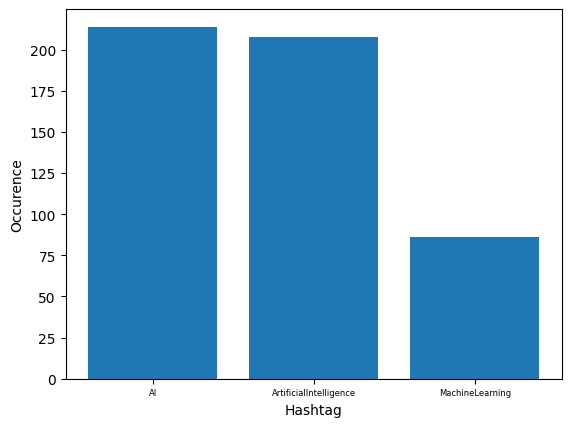

{'AI': 214, 'ArtificialIntelligence': 208, 'MachineLearning': 86}

In [24]:
# Test for Top k hashtags
all_hashtag()
top_hashtag(3)

In [ ]:
# Test for Top k users
all_users()
top_users(4)

In [ ]:
# Test for Top k mentions
all_mentions()
top_mention(7)

In [ ]:
all_tweet_hashtag("DataScience")

In [ ]:
all_tweet_mention("SpirosMargaris")

In [ ]:
df_data

In [ ]:
all_hashtag()

In [ ]:
user_specified_hashtag("FEATURED")

In [ ]:
user_mentionned(1415291886860967936)

In [ ]:
all_tweet_hashtag("machine")

In [ ]:
tweets[0].get_author()

In [22]:
text_cleaning("En été il fait très chaud 🌞, par contre en hiver il fait super froid 🥶")

'En été il fait très chaud , par contre en hiver il fait super froid '